***
***

# **COVID-19 Vaccination Progress**

## *8) SARIMA Model (Daily Vaccinations)*

***
***

## Table of Contents

| 1. INTRODUCTION | 2. Visualisations | 3. SUMMARY |
|----|----|----|
| *1.1 Dataset Characteristics* | *2.1 Importing Libraries and Data* | 3.1 Key Findings |
| | *2.2 SARIMA Model* | 3.2 Next Steps |

***
***

## 1. INTRODUCTION

In this notebook we use the time series datasets (original annd detrended) generated in notebook 6 (Feature Selection for Prediction and Time Series Specific EDA) in a seasonal ARIMA model. ARIMA models are a combination of auto-regressive (AR) and moving average (MA) models along with the integration of differencing. The auto-regressive part determines the relationship between an observation and a certain number of lagged observations, whereas the moving average part determines the relationship between an observation and the residual error obtained by using a moving average model on the lagged observations. The integrated part is the differencing of the actual observations to make the time series stationary.

***

### 1.1 Dataset Characteristics

1) Our 3 timeseries (Worldwide, Germany & Israel) contain the following detrended feature:

| FEATURE | description | comment |
|----|----|----|
| **date** | data entry (13th December 2020 to 24th March 2021) | - |
| **daily_vaccinations_raw** | daily vaccinations as CHANGE COMPARED TO PREVIOUS DAY | calculation: total_vaccinations |
***
***

## 2. IMPORTS AND DATA PREPARATION

***

### 2.1 Importing Libraries and Data

+ Import numpy (linear algebra), pandas (data processing), auto-arima and metric calulations (sklearn).
+ Import datasets on COVID-19 vaccination progress from notebook 6.

In [1]:
#Import basic libraries
import numpy as np #linear algebra
import pandas as pd #data processing

#Libraries for visualization
import matplotlib.pyplot as plt

#Import auto-ARIMA
from pmdarima.arima import auto_arima

#Import libraries for statistics
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error

#Suppress pandas future warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

#Plot settings
%matplotlib inline
dpi_var=150

In [2]:
#Import detrended datasets
#Worldwide - daily vaccinations (raw)
df_worldwide = pd.read_csv('data/df_worldwide.csv', parse_dates=['date'])
df_worldwide.sort_values('date', inplace=True)
df_worldwide = df_worldwide.set_index('date')

#Germany -  daily vaccinations (raw)
df_germany = pd.read_csv('data/df_germany.csv', parse_dates=['date'])
df_germany.sort_values('date', inplace=True)
df_germany = df_germany.set_index('date')

#Israel -  daily vaccinations (raw)
df_israel = pd.read_csv('data/df_israel.csv', parse_dates=['date'])
df_israel.sort_values('date', inplace=True)
df_israel = df_israel.set_index('date')

***

### 2.1 SARIMA Model

In this section we investigate seasonal ARIMA for 3 timeseries (daily_vaccinations_raw --- worldwide, Germany, Israel). In order to apply an ARIMA model we need the timeseries to be trend-stationary, which we achieved in notebook 6. We will use auto-arima to run a seasonal arima model with weekly seasonality and search through different parameters with respect to the AR and MA lag orders.

Key parameters of the seasonal auto-ARIMA model:

+ m --- Periodicity of the data's seasonal cycle

+ d --- Order of integrated differencing

+ p --- AR lag order: Determines how many previous datapoints will be used for autoregressive part

+ q --- MA lag order: Determines how many previous datapoints will be used for moving average part


#### **TASK 1**: Worldwide Daily Vaccinations (raw)

1) Split data into train and test
2) Train model and predict
3) Visualise results
4) Evaluation metrics

**KEY FINDINGS**

1) Since there are only few datapoints (102) available at this point in time due to vaccination only having started in December 2020 we will only take a very small set (10 days) for testing. Advantageously fresh data is being generated continuously and we can later test out models on newer data (April 2021).
2) Sometimes there are some missing values right at the start or end of the timeseries, due to vaccinations not having started at the same time in all countries and due to data being reported with a slight delay (i.e. not all countries having reported data for the last day, i.e. 24th March 2021). In addition, as in this case the number to start of with might be zero and hence needs to be dropped for the model.
3) For training the model the seasonal periods were included, i.e. 7, and the degree of differencing for the detrended deris was set to 1. The AR and MA parameter ranges for trend and seasonality were chosen based on the ACF and PACF plot in notebook 6.
4) The plot of the outcome show clearly that so far we failed to capture the time series and need to return to further investigations through EDA. With regard to the diagnostic plots, the red KDE line does not follow closely with the N(0,1) line, and indication that the residual are not normally distriibuted. The Q-Q-plot shows that the ordered distribution of residuals does not follow the linear trend of the samples taken from a standard normal distribution with N(0,1) very well, again indicating that the residuals are not normally distributed. The Correlogram shows that the time series residuals have low correlation with lagged versions of itself.

In [3]:
#Split data into train and test set
df_train, df_test = df_worldwide[:'2021-03-14'].reset_index(), df_worldwide['2021-03-15':].reset_index()

#Check number of records in train and test
print(df_train.shape, df_test.shape)

(84, 2) (10, 2)


In [4]:
#Set date as index
df_train = df_train.set_index('date')
df_test = df_test.set_index('date')

#Drop any rows that contain zeros or are empty at the beginning of the series (i.e. in train)
df_train.replace([0], np.nan, inplace=True)
df_train.dropna(inplace=True)

#Drop any rows that contain zeros or are empty at the very end of the series (i.e. in test)
df_test.replace([0], np.nan, inplace=True)
df_test.dropna(inplace=True)

In [5]:
#Auto ARIMA model with seasonality
arima_model = auto_arima(df_train,
                         m=7, #periods in season
                         d=1, #degree of differencing
                         start_p=1, start_q=1, #p (AR lag order), q (MA lag order)
                         max_p=7, max_q=7,
                         D=1, #cap. letters = seasonality parameters
                         start_P=1, start_Q=1,
                         max_P=7, max_Q=7,
                         test='adf', #most sensitive test during differencing 
                         alpha=0.05,
                         scoring='mse', #default
                         suppress_warnings=True,
                         seasonal = True,
                         stationarity= False,
                         stepwise=True,
                         )

#Fit the model
fitted_model = arima_model.fit(df_train) 
print(fitted_model.summary())

#Predict values
forecast_values = fitted_model.predict(len(df_test), alpha=0.05) 
fcv_series = pd.Series(forecast_values[0], index=df_test.index)

                                      SARIMAX Results                                      
Dep. Variable:                                   y   No. Observations:                   84
Model:             SARIMAX(3, 1, 2)x(0, 1, [1], 7)   Log Likelihood               -1137.042
Date:                             Wed, 28 Apr 2021   AIC                           2288.085
Time:                                     09:47:49   BIC                           2304.400
Sample:                                          0   HQIC                          2294.605
                                              - 84                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4428      0.388     -1.141      0.254      -1.204       0.318
ar.L2         -0.4211      

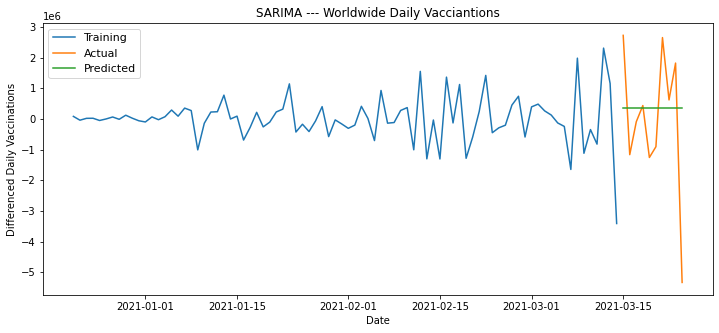

In [6]:
#Plot original and SARIMA predicted values
plt.figure(figsize=(12,5))

#Define plots of train, test and predicted data
plt.plot(df_train, label='Training')
plt.plot(df_test, label='Actual')
plt.plot(fcv_series,label='Predicted')

#Set title, labels and legend
plt.title('SARIMA --- Worldwide Daily Vacciantions')
plt.xlabel('Date')
plt.ylabel('Differenced Daily Vaccinations')
plt.legend(loc='upper left', fontsize=11)

plt.show();

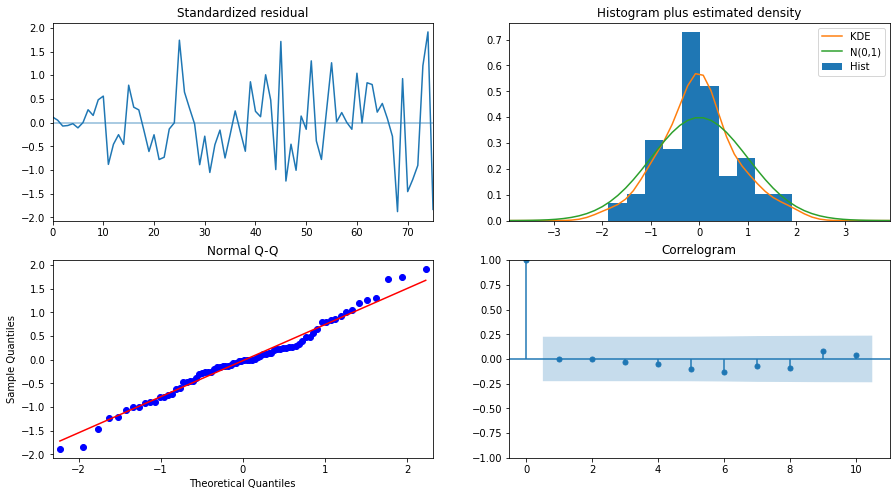

In [7]:
#Plotting diagnostics of the SARIMA model
fitted_model.plot_diagnostics(figsize=(15,8))
plt.show();

In [8]:
#Evaluation metrics for SARIMA model
mae = mean_absolute_error(df_test.values, fcv_series)
rmse = mean_squared_error(df_test.values, fcv_series, squared=False)
mape = mean_absolute_percentage_error(df_test.values, fcv_series)

print('====='*10)
print(f'The metrics for the worldwide SARIMA model are:')
print('====='*10)
print(f'MAE score: {round(mae,2)}')
print(f'RMSE score: {round(rmse,2)}')
print(f'MAPE score: {round(mape,2)}')
print('====='*10)

The metrics for the worldwide SARIMA model are:
MAE score: 1701106.5
RMSE score: 2283889.58
MAPE score: 1.31


#### **TASK 2**: Daily Vaccinations (raw) (Germany)

1) Split data into train and test
2) Train model and predict
3) Visualise results
4) Evaluation metrics

**KEY FINDINGS**

1) Kept last 9 days for testing, since no data for 24th March at this point in time.
2) Dropped entries with zeros at the start of the series, and the entry for 24th March, as it had not been reported yet.
3) For training the model the seasonal periods were included, i.e. 7, and the degree of differencing for the detrended deris was set to 1. The AR and MA parameter ranges for trend and seasonality were chosen based on the ACF and PACF plot in notebook 6. (same as the above model)
4) The plot of the outcome show clearly that so far we failed to capture the time series and need to return to further investigations through EDA. With regard to the diagnostic plots, the red KDE line does not follow closely with the N(0,1) line, and indication that the residual are not normally distriibuted. The Q-Q-plot shows that the ordered distribution of residuals does not follow the linear trend of the samples taken from a standard normal distribution with N(0,1) very well at the start and end, again indicating that the residuals are not normally distributed. The Correlogram shows that the time series residuals have low correlation with lagged versions of itself. (same as the above model)

In [9]:
#Split data into train and test set
df_train, df_test = df_germany[:'2021-03-14'].reset_index(), df_germany['2021-03-15':].reset_index()

#Check number of records in train and test
print(df_train.shape, df_test.shape)

(70, 2) (9, 2)


In [10]:
#Set date as index
df_train = df_train.set_index('date')
df_test = df_test.set_index('date')

#Drop any rows that contain zeros or are empty at the beginning of the series (i.e. in train)
df_train.replace([0], np.nan, inplace=True)
df_train.dropna(inplace=True)

#Drop any rows that contain zeros or are empty at the very end of the series (i.e. in test)
df_test.replace([0], np.nan, inplace=True)
df_test.dropna(inplace=True)

In [11]:
#Auto ARIMA model with seasonality
arima_model = auto_arima(df_train,
                         m=7, #periods in season
                         d=1, #degree of differencing
                         start_p=1, start_q=1, #p (AR lag order), q (MA lag order)
                         max_p=7, max_q=7,
                         D=1, #cap. letters = seasonality parameters
                         start_P=1, start_Q=1,
                         max_P=7, max_Q=7,
                         test='adf', #most sensitive test during differencing 
                         alpha=0.05,
                         scoring='mse', #default
                         suppress_warnings=True,
                         seasonal = True,
                         stationarity= False,
                         stepwise=True,
                         )

#Fit the model
fitted_model = arima_model.fit(df_train) 
print(fitted_model.summary())

#Predict values
forecast_values = fitted_model.predict(len(df_test), alpha=0.05) 
fcv_series = pd.Series(forecast_values[0], index=df_test.index)

                                       SARIMAX Results                                        
Dep. Variable:                                      y   No. Observations:                   70
Model:             SARIMAX(0, 1, 0)x(0, 1, [1, 2], 7)   Log Likelihood                -676.179
Date:                                Wed, 28 Apr 2021   AIC                           1358.358
Time:                                        09:47:52   BIC                           1364.739
Sample:                                             0   HQIC                          1360.863
                                                 - 70                                         
Covariance Type:                                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.S.L7       -1.4856      0.203     -7.330      0.000      -1.883      -1.088
ma.

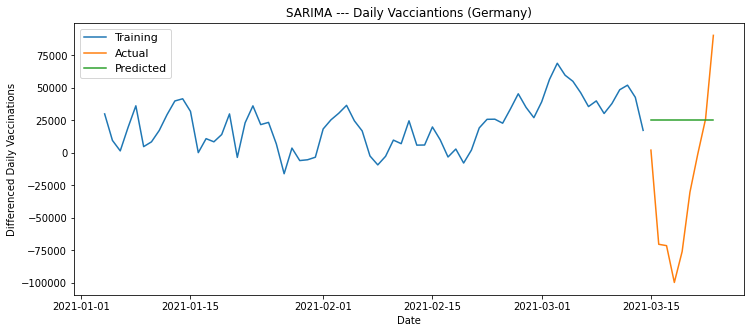

In [12]:
#Plot original and SARIMA predicted values
plt.figure(figsize=(12,5))

#Define plots of train, test and predicted data
plt.plot(df_train, label='Training')
plt.plot(df_test, label='Actual')
plt.plot(fcv_series,label='Predicted')

#Set title, labels and legend
plt.title('SARIMA --- Daily Vacciantions (Germany)')
plt.xlabel('Date')
plt.ylabel('Differenced Daily Vaccinations')
plt.legend(loc='upper left', fontsize=11)

plt.show();

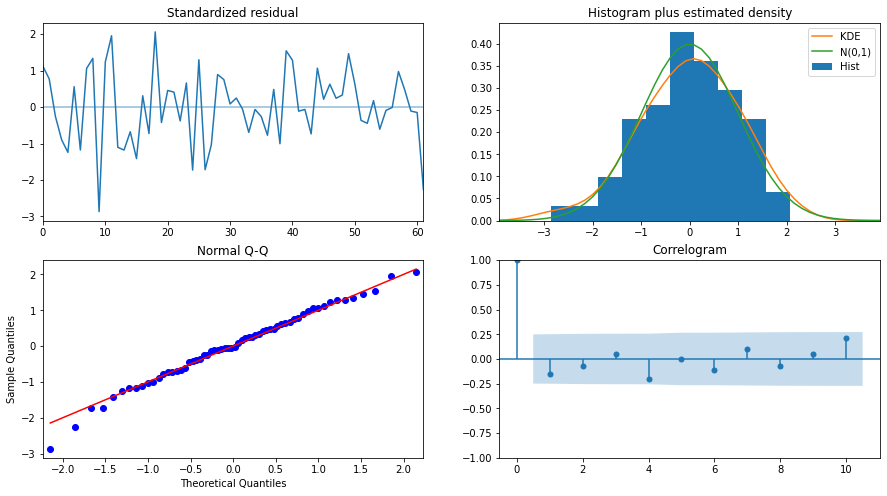

In [13]:
#Plotting diagnostics of the SARIMA model
fitted_model.plot_diagnostics(figsize=(15,8))
plt.show();

In [14]:
#Evaluation metrics for SARIMA model
mae = mean_absolute_error(df_test.values, fcv_series)
rmse = mean_squared_error(df_test.values, fcv_series, squared=False)
mape = mean_absolute_percentage_error(df_test.values, fcv_series)

print('====='*10)
print(f'The metrics for the SARIMA model for Germany are:')
print('====='*10)
print(f'MAE score: {round(mae,2)}')
print(f'RMSE score: {round(rmse,2)}')
print(f'MAPE score: {round(mape,2)}')
print('====='*10)

The metrics for the SARIMA model for Germany are:
MAE score: 65655.67
RMSE score: 76877.18
MAPE score: 5.15


#### **TASK 3**: Daily Vaccinations (raw) (Israel)

1) Split data into train and test
2) Train model and predict
3) Visualise results
4) Evaluation metrics

**KEY FINDINGS**

1) Kept last 9 days for testing, since no data for 24th March at this point in time.
2) Dropped entries with zeros at the start of the series, and the entry for 24th March, as it had not been reported yet.
3) For training the model the seasonal periods were included, i.e. 7, and the degree of differencing for the detrended deris was set to 1. The AR and MA parameter ranges for trend and seasonality were chosen based on the ACF and PACF plot in notebook 6. (same as the above models)
4) The plot of the outcome show clearly that so far we failed to capture the time series and need to return to further investigations through EDA. With regard to the diagnostic plots, the red KDE line does not follow closely with the N(0,1) line, and indication that the residual are not normally distriibuted. The Q-Q-plot shows that the ordered distribution of residuals does not follow the linear trend of the samples taken from a standard normal distribution with N(0,1) very well, again indicating that the residuals are not normally distributed. The Correlogram shows that the time series residuals have low correlation with lagged versions of itself. (same as the above models)

In [15]:
#Split data into train and test set
df_train, df_test = df_israel[:'2021-03-14'].reset_index(), df_israel['2021-03-15':].reset_index()

#Check number of records in train and test
print(df_train.shape, df_test.shape)

(55, 2) (9, 2)


In [16]:
#Set date as index
df_train = df_train.set_index('date')
df_test = df_test.set_index('date')

#Drop any rows that contain zeros or are empty at the beginning of the series (i.e. in train)
df_train.replace([0], np.nan, inplace=True)
df_train.dropna(inplace=True)

#Drop any rows that contain zeros or are empty at the very end of the series (i.e. in test)
df_test.replace([0], np.nan, inplace=True)
df_test.dropna(inplace=True)

In [17]:
#Auto ARIMA model with seasonality
arima_model = auto_arima(df_train,
                         m=7, #periods in season
                         d=1, #degree of differencing
                         start_p=1, start_q=1, #p (AR lag order), q (MA lag order)
                         max_p=7, max_q=7,
                         D=1, #cap. letters = seasonality parameters
                         start_P=1, start_Q=1,
                         max_P=7, max_Q=7,
                         test='adf', #most sensitive test during differencing 
                         alpha=0.05,
                         scoring='mse', #default
                         suppress_warnings=True,
                         seasonal = True,
                         stationarity= False,
                         stepwise=True,
                         )

#Fit the model
fitted_model = arima_model.fit(df_train) 
print(fitted_model.summary())

#Predict values
forecast_values = fitted_model.predict(len(df_test), alpha=0.05) 
fcv_series = pd.Series(forecast_values[0], index=df_test.index)

                                      SARIMAX Results                                      
Dep. Variable:                                   y   No. Observations:                   55
Model:             SARIMAX(2, 1, 3)x(0, 1, [1], 7)   Log Likelihood                -594.842
Date:                             Wed, 28 Apr 2021   AIC                           1203.685
Time:                                     09:48:02   BIC                           1216.636
Sample:                                          0   HQIC                          1208.559
                                              - 55                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.1415      0.189     -6.030      0.000      -1.512      -0.770
ar.L2         -0.8976      

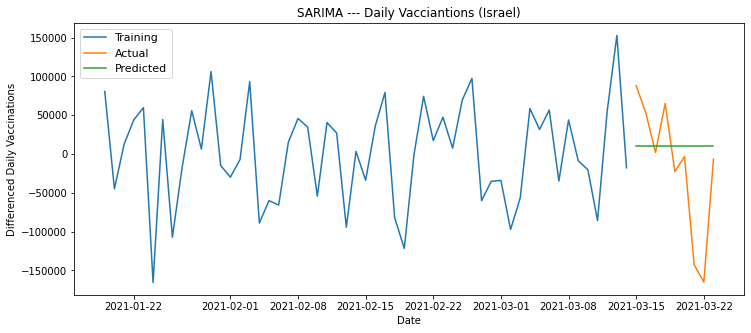

In [18]:
#Plot original and SARIMA predicted values
plt.figure(figsize=(12,5))

#Define plots of train, test and predicted data
plt.plot(df_train, label='Training')
plt.plot(df_test, label='Actual')
plt.plot(fcv_series,label='Predicted')

#Set title, labels and legend
plt.title('SARIMA --- Daily Vacciantions (Israel)')
plt.xlabel('Date')
plt.ylabel('Differenced Daily Vaccinations')
plt.legend(loc='upper left', fontsize=11)

plt.show();

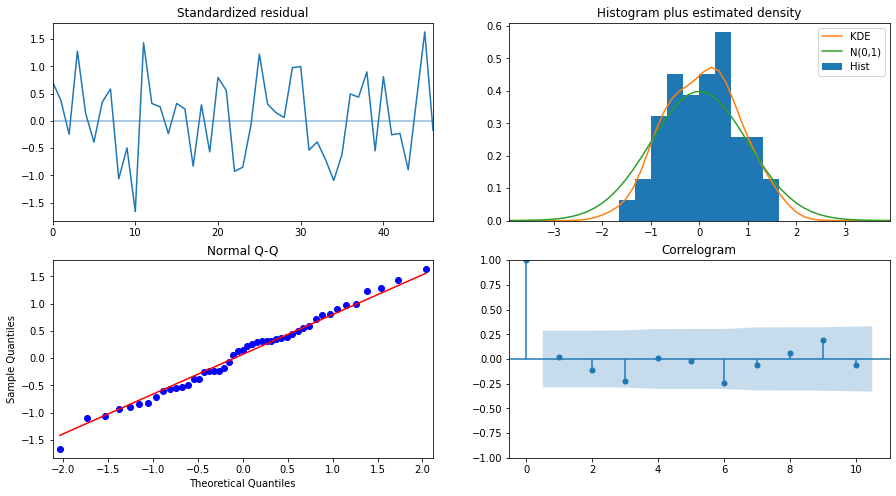

In [19]:
#Plotting diagnostics of the SARIMA model
fitted_model.plot_diagnostics(figsize=(15,8))
plt.show();

In [20]:
#Evaluation metrics for SARIMA model
mae = mean_absolute_error(df_test.values, fcv_series)
rmse = mean_squared_error(df_test.values, fcv_series, squared=False)
mape = mean_absolute_percentage_error(df_test.values, fcv_series)

print('====='*10)
print(f'The metrics for the SARIMA model for Israel are:')
print('====='*10)
print(f'MAE score: {round(mae,2)}')
print(f'RMSE score: {round(rmse,2)}')
print(f'MAPE score: {round(mape,2)}')
print('====='*10)

The metrics for the SARIMA model for Israel are:
MAE score: 63743.02
RMSE score: 85920.1
MAPE score: 1.85


***
***

## 3. SUMMARY

***

### 3.1 Key Findings

So far the SARIMA model has not performed well with respect to our 3 univariate timeseries. In fact, one could say it has not performed at all (with MAPE scores >100% and a prediction of a straight line). This is something we could have achieved with a simple naive method. Hence, we need to return to the EDA and reinvestigate detrending the timeseries via alternative methods, as during optimisation we tested different hyperparameters, however without success. Shown above are only those hyperparameters we selected knowledge-based on the EDA of the timeseries.

***

### 3.2 Next Steps

As next steps we consider returning to detrending the timeseries and attempting different patterns, such as 2 or 3 days, as well as logarithmic scale.


For now, first of all we will continue with investigating FB Prophet as an alternative model in the next notebook (9).

***